In [1]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,085 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,129 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/univers

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Read in real_estate_sales.csv data from the S3 Bucket realestateproj
from pyspark import SparkFiles
url ="https://creditcardeligibility.s3.ap-southeast-2.amazonaws.com/dataset.csv"
spark.sparkContext.addFile(url)

credit_card_eligibility = spark.read.csv(SparkFiles.get("dataset.csv"), header=True, inferSchema=True)

credit_card_eligibility.show(5)

+-------+------+-------+------------+----------+-----+-----+----------+------------+----------+--------------+------------+------------------+------------------+--------------------+--------------------+--------------------+-----------------+---------------+------+
|     ID|Gender|Own_car|Own_property|Work_phone|Phone|Email|Unemployed|Num_children|Num_family|Account_length|Total_income|               Age|    Years_employed|         Income_type|      Education_type|       Family_status|     Housing_type|Occupation_type|Target|
+-------+------+-------+------------+----------+-----+-----+----------+------------+----------+--------------+------------+------------------+------------------+--------------------+--------------------+--------------------+-----------------+---------------+------+
|5008804|     1|      1|           1|         1|    0|    0|         0|           0|         2|            15|    427500.0| 32.86857361889703|12.435573625741801|             Working|    Higher education

In [22]:
# Import the required modules
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [23]:
# Convert dataframe to pandas
df_creditcard = credit_card_eligibility.toPandas()

In [24]:
# Check the DataFrame
df_creditcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int32  
 1   Gender           9709 non-null   int32  
 2   Own_car          9709 non-null   int32  
 3   Own_property     9709 non-null   int32  
 4   Work_phone       9709 non-null   int32  
 5   Phone            9709 non-null   int32  
 6   Email            9709 non-null   int32  
 7   Unemployed       9709 non-null   int32  
 8   Num_children     9709 non-null   int32  
 9   Num_family       9709 non-null   int32  
 10  Account_length   9709 non-null   int32  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [25]:
# Generate dummies for the categorical features and drop the non_feature column "ID"
modelling_df = pd.get_dummies(df_creditcard)
modelling_df = modelling_df.drop(columns="ID")
modelling_df.head(3)

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,...,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
0,1,1,1,1,0,0,0,0,2,15,...,False,False,False,True,False,False,False,False,False,False
1,1,1,1,0,0,0,0,0,2,29,...,False,False,False,False,False,False,False,False,True,False
2,0,0,1,0,1,1,0,0,1,4,...,False,False,False,False,False,False,True,False,False,False


In [26]:
# Check the modelling DataFrame
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Gender                                        9709 non-null   int32  
 1   Own_car                                       9709 non-null   int32  
 2   Own_property                                  9709 non-null   int32  
 3   Work_phone                                    9709 non-null   int32  
 4   Phone                                         9709 non-null   int32  
 5   Email                                         9709 non-null   int32  
 6   Unemployed                                    9709 non-null   int32  
 7   Num_children                                  9709 non-null   int32  
 8   Num_family                                    9709 non-null   int32  
 9   Account_length                                9709 non-null   i

In [27]:
# Make a copy of the DataFrame modelling_df and split the features
X = modelling_df.copy()
X.drop("Target", axis=1, inplace=True)
# Check the features
X.head(2)

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,...,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
0,1,1,1,1,0,0,0,0,2,15,...,False,False,False,True,False,False,False,False,False,False
1,1,1,1,0,0,0,0,0,2,29,...,False,False,False,False,False,False,False,False,True,False


In [28]:
# Get and check the target
y=modelling_df["Target"].ravel()
y[:2]

array([1, 0], dtype=int32)

In [29]:
# Splitting the data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [30]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [31]:
# Fit the scaler on the training data
X_scaler = scaler.fit(X_train)

In [32]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Fitting the Random Forest Model

In [33]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [34]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [35]:
 # Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [36]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [37]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2078,2
Actual 1,347,1


Accuracy Score : 0.8562602965403624
Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2080
           1       0.33      0.00      0.01       348

    accuracy                           0.86      2428
   macro avg       0.60      0.50      0.46      2428
weighted avg       0.78      0.86      0.79      2428



Feature Importance

In [38]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
important_features = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
important_features[:20]

[(0.1719755401090585, 'Age'),
 (0.14316837984422426, 'Account_length'),
 (0.12680737265147168, 'Years_employed'),
 (0.12534694991263326, 'Total_income'),
 (0.03172016023869808, 'Num_family'),
 (0.022972874410537615, 'Num_children'),
 (0.02284912140715757, 'Own_car'),
 (0.02180895776813514, 'Phone'),
 (0.02171162316004561, 'Own_property'),
 (0.02042271581256511, 'Gender'),
 (0.01725835493840302, 'Work_phone'),
 (0.015760844958158094, 'Income_type_Working'),
 (0.014864222204069083, 'Education_type_Secondary / secondary special'),
 (0.014575467818451359, 'Family_status_Married'),
 (0.01442705407221932, 'Income_type_Commercial associate'),
 (0.013797068150789975, 'Education_type_Higher education'),
 (0.012939985111652225, 'Occupation_type_Laborers'),
 (0.012627658564639124, 'Occupation_type_Other'),
 (0.012092294712475473, 'Email'),
 (0.011458985165218455, 'Family_status_Single / not married')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

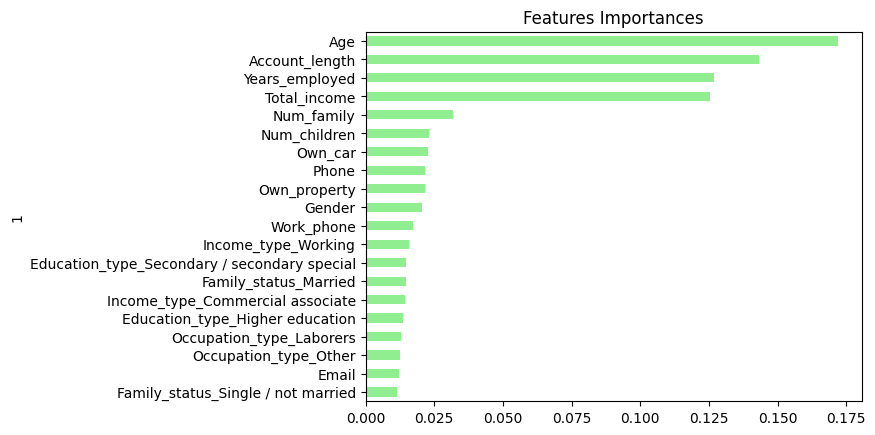

In [39]:
# Visualize the features by importance
importances_df = pd.DataFrame(important_features[:20])
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

Optimise the Model

In [40]:
# winsorize the continuous features
from scipy.stats.mstats import winsorize
modelling_df["Age_w"]= winsorize(modelling_df["Age"], limits=(0.05, 0.95))
modelling_df["Account_length_w"]= winsorize(modelling_df["Account_length"], limits=(0.05, 0.95))
modelling_df["Years_employed_w"]= winsorize(modelling_df["Years_employed"], limits=(0.05, 0.95))
modelling_df["Total_income_w"]= winsorize(modelling_df["Total_income"], limits=(0.05, 0.95))
modelling_df["Num_family_w"]= winsorize(modelling_df["Num_family"], limits=(0.05, 0.95))
modelling_df["Num_children_w"]= winsorize(modelling_df["Num_children"], limits=(0.05, 0.95))
modelling_df.head(3)

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,...,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff,Age_w,Account_length_w,Years_employed_w,Total_income_w,Num_family_w,Num_children_w
0,1,1,1,1,0,0,0,0,2,15,...,False,False,False,False,26.593291,3,0.0,67500.0,1,0
1,1,1,1,0,0,0,0,0,2,29,...,False,False,True,False,26.593291,3,0.0,67500.0,1,0
2,0,0,1,0,1,1,0,0,1,4,...,True,False,False,False,26.593291,3,0.0,67500.0,1,0


In [41]:
# Re_split our preprocessed data into our features and target arrays
y = modelling_df["Target"]
# keep the most important features including the winsorised columns
X = modelling_df[["Age_w", "Account_length_w", "Years_employed_w", "Total_income_w",
                 "Num_family_w", "Num_children_w", "Own_car", "Phone", "Own_property",
                 "Gender", "Work_phone", "Income_type_Working", "Education_type_Secondary / secondary special",
                  "Family_status_Married", "Income_type_Commercial associate", "Education_type_Higher education",
                  "Occupation_type_Laborers","Occupation_type_Other","Email"
                 ]]
X.head(3)

,Age_w,Account_length_w,Years_employed_w,Total_income_w,Num_family_w,Num_children_w,Own_car,Phone,Own_property,Gender,Work_phone,Income_type_Working,Education_type_Secondary / secondary special,Family_status_Married,Income_type_Commercial associate,Education_type_Higher education,Occupation_type_Laborers,Occupation_type_Other,Email
0,26.593291,3,0.0,67500.0,1,0,1,0,1,1,1,True,False,False,False,True,False,True,0
1,26.593291,3,0.0,67500.0,1,0,1,0,1,1,0,True,True,True,False,False,False,False,0
2,26.593291,3,0.0,67500.0,1,0,0,1,1,0,0,False,True,False,True,False,False,False,1


In [42]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [43]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network model
nn_model = Sequential()

# Add input layer and first hidden layer
nn_model.add(Dense(units=20, input_dim=X_train_scaled.shape[1], activation='relu'))

# Add the output layer
nn_model.add(Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                400       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 421 (1.64 KB)
Trainable params: 421 (1.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
# Train the model
hitory = nn_model.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
228/228 [==============================] - 1s 2ms/step - loss: 0.9126 - accuracy: 0.4574
Epoch 2/50
228/228 [==============================] - 1s 2ms/step - loss: 0.4362 - accuracy: 0.8646
Epoch 3/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4031 - accuracy: 0.8679
Epoch 4/50
228/228 [==============================] - 1s 3ms/step - loss: 0.3989 - accuracy: 0.8679
Epoch 5/50
228/228 [==============================] - 1s 5ms/step - loss: 0.3965 - accuracy: 0.8679
Epoch 6/50
228/228 [==============================] - 1s 3ms/step - loss: 0.3948 - accuracy: 0.8679
Epoch 7/50
228/228 [==============================] - 1s 2ms/step - loss: 0.3934 - accuracy: 0.8679
Epoch 8/50
228/228 [==============================] - 0s 2ms/step - loss: 0.3924 - accuracy: 0.8679
Epoch 9/50
228/228 [==============================] - 1s 2ms/step - loss: 0.3915 - accuracy: 0.8679
Epoch 10/50
228/228 [==============================] - 1s 3ms/step - loss: 0.3907 - accuracy: 0.8679

In [47]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

76/76 - 0s - loss: 0.3997 - accuracy: 0.8678 - 327ms/epoch - 4ms/step
Loss: 0.39969348907470703, Accuracy: 0.8677924275398254
